In [15]:
import z1_save_oligos, z2_save_jaspar, z3_transformations
import pandas as pd
import numpy as np
import re

#Data processing frameworks
import pandas as pd, numpy as np, scipy.stats as stats
#Plotting & visualization
import seaborn as sns, matplotlib.pyplot as plt
import umap

#Pytorch
import torch, torch.nn as nn
from torch.autograd import Variable

# FETCH DATA
# note, this code will need to be run only once on a running colab instance.
# once it has been run, you may comment it out.
# !git clone https://github.com/gifford-lab/6884-antibodies-data.git


In [17]:

#LOAD JASPAR & OLIGO DATA
jaspar = z2_save_jaspar.load_jaspar()
oligos,oligos_by_exp = z1_save_oligos.load_oligos_plus()
oligos_by_exp["analysis_group_key"] = oligos_by_exp.exp.copy()
all_obe = oligos_by_exp.reset_index().loc[lambda x:x.mutant_num<5].groupby(["starts","mutant_num","analysis_group_key"]).norm_mu.mean()


In [18]:
all_obe.Sequences.unique()

AttributeError: 'Series' object has no attribute 'Sequences'

In [201]:

def create_kmers(seq):
    k = 4
    kmer_keys =  [f"{l1}{l2}{l3}{l4}" for l1 in "ATGC" for l2  in "ATGC" for l3 in "ATGC" for l4 in "ATGC" ]
    kdict = dict([[k,0] for k in kmer_keys] )
    for i in range(len(seq) - len(kmer_keys[0])):
        kdict[seq[i:i+4]] +=1 
    return pd.Series(kdict)
    

In [202]:

kmer_counts = pd.Series(oligos_by_exp.Sequences.unique()).apply(lambda x: create_kmers(x))

(9903, 64)

In [206]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim =100, output_dim =1, dropout = False):
        self.do_dropout = dropout
        super(ANNModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity 1
        # [STUDENTS] Add in a rectified linear unit to allow nonlinearity in the the first hidden layer transform.
        self.relu1 = nn.ReLU()
        
        # Linear function 3: 100 --> 100
         # [STUDENTS] Add in a PyTorch fully connected linear maintaining the size of the hidden layer.
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)

        self.ln4 = nn.Linear(hidden_dim, hidden_dim)  

        self.dp4 = nn.Dropout( 0.4)#, #50 % probability 
    
        self.ln5 = nn.Linear(hidden_dim, hidden_dim)  
    
        
        # Non-linearity 3
        # [STUDENTS] Add in a ELU to allow nonlinearity in the final hidden layer transform.
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        
        # Linear function 2
        out = self.fc3(out)
        
        if(self.do_dropout):
            #print ("ADDING DROPOUT LAYER")
            #out = self.ln4(out)
            out = self.dp4(out)
            #out = self.ln5(out)
            
        # Non-linearity 2
        # out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out


In [213]:
# This section will train the model, creating trained parameters. Choose a learning rate and you'll be ready to go!
def run_model_training(model, train, test=None, batch_size=1000, n_iters=10000, num_epochs= 10,learning_rate=.005):
  # SGD Optimizer
  #[STUDENTS] Choose a learning rate for your optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

  count = 0 

  for epoch in range(num_epochs):
      #print (f'training loop: Running epoch {epoch} of {num_epochs}')
      for i, (images, labels) in enumerate(train_loader):

          #images = np.reshape(images,(-1,20,30))
          labels = np.reshape(labels,(-1,1)).float()

          train_set = Variable(images.view(-1,64*4).float())#-1, 28*28))
          labels = Variable(labels)
          
          # Clear gradients
          optimizer.zero_grad()
          
          # Forward propagation
          outputs = model(train_set)
          
          # Calculate MSE loss
          loss_func = torch.nn.MSELoss()
          loss = loss_func(outputs, labels) 

          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()

          count +=1;
          if count %100 == 0: print('Training set loss--iteration: {}  Loss: {}'.format(count, loss.data))    

          # [STUDENTS / OPTIONAL] set up a conditional print statement which 
          # tests the accuracy of the current trained model on testing data
          # in order to judge the correct learning rate. Is your model performance
          # improving in each epoch?
          # 
          # for images, labels in test_loader: [...]
              

        




In [208]:
test_idxs = np.random.choice(range(len(features)),200)
train_idxs = np.array(list(set(range(len(features))).symmetric_difference(test_idxs)))
all_features = kmer_counts.sort_index()
all_targets = oligos_by_exp.groupby("Sequences").mu.mean().sort_index()

train_features = all_features.iloc[train_idxs]
train_targets = all_targets.iloc[train_idxs]
test_features = all_features.iloc[test_idxs]
test_targets = all_targets.iloc[test_idxs]

featuresTrainRandomSplit = torch.from_numpy(train_features.values).type(torch.FloatTensor)
targetsTrainRandomSplit = torch.from_numpy(train_targets.values).type(torch.FloatTensor)

featuresTestRandomSplit = torch.from_numpy(test_features.values).type(torch.FloatTensor)
targetsTestRandomSplit = torch.from_numpy(test_targets.values).type(torch.FloatTensor)

train_set = torch.utils.data.TensorDataset(featuresTrainRandomSplit,targetsTrainRandomSplit)
test_set = torch.utils.data.TensorDataset(featuresTestRandomSplit,targetsTestRandomSplit)


In [209]:

# batch_size, epoch and iteration
batch_size = 50
n_iters = 15000
#create model & training set
input_dim = 64* 4
num_epochs = int(n_iters / (len(featuresTrainRandomSplit) / batch_size))

model = ANNModel(input_dim, hidden_dim = 15, output_dim = 1)
#run training
run_model_training(model, train_set,test = test_set, batch_size=batch_size, n_iters=n_iters, num_epochs=num_epochs, learning_rate = .002)


Training set loss--iteration: 100  Loss: 8.609663963317871
Training set loss--iteration: 200  Loss: 1.1950626373291016
Training set loss--iteration: 300  Loss: 1.4607475996017456
Training set loss--iteration: 400  Loss: 1.2533165216445923
Training set loss--iteration: 500  Loss: 1.2155252695083618
Training set loss--iteration: 600  Loss: 4.1617326736450195
Training set loss--iteration: 700  Loss: 1.9474092721939087
Training set loss--iteration: 800  Loss: 0.4408220052719116
Training set loss--iteration: 900  Loss: 1.237488031387329
Training set loss--iteration: 1000  Loss: 1.0035953521728516
Training set loss--iteration: 1100  Loss: 2.0024008750915527
Training set loss--iteration: 1200  Loss: 0.2852460443973541
Training set loss--iteration: 1300  Loss: 1.5948669910430908
Training set loss--iteration: 1400  Loss: 1.909821629524231
Training set loss--iteration: 1500  Loss: 0.3636046350002289
Training set loss--iteration: 1600  Loss: 0.5962837338447571
Training set loss--iteration: 1700  

KeyboardInterrupt: 

In [219]:

# batch_size, epoch and iteration
batch_size = 50
n_iters = 15000
#create model & training set
input_dim = 64*4
num_epochs = int(n_iters / (len(featuresTrainRandomSplit) / batch_size))


model_dropout2 = ANNModel(input_dim, hidden_dim =15, output_dim = 1, dropout = True)
#run training
run_model_training(model_dropout2, train_set,test = test_set, batch_size=batch_size, n_iters=n_iters, num_epochs=num_epochs, learning_rate = .001)


Training set loss--iteration: 100  Loss: 7.350094318389893
Training set loss--iteration: 200  Loss: 0.8189486861228943
Training set loss--iteration: 300  Loss: 1.1590336561203003
Training set loss--iteration: 400  Loss: 7.612275123596191
Training set loss--iteration: 500  Loss: 0.9006824493408203
Training set loss--iteration: 600  Loss: 2.7971723079681396
Training set loss--iteration: 700  Loss: 10.151224136352539
Training set loss--iteration: 800  Loss: 6.198485851287842
Training set loss--iteration: 900  Loss: 1.8913052082061768
Training set loss--iteration: 1000  Loss: 3.1236040592193604
Training set loss--iteration: 1100  Loss: 1.087859869003296
Training set loss--iteration: 1200  Loss: 4.6946868896484375
Training set loss--iteration: 1300  Loss: 1.8925706148147583
Training set loss--iteration: 1400  Loss: 0.5458353161811829
Training set loss--iteration: 1500  Loss: 3.57850980758667
Training set loss--iteration: 1600  Loss: 2.5873961448669434
Training set loss--iteration: 1700  Los

In [210]:

# batch_size, epoch and iteration
batch_size = 100
n_iters = 15000
#create model & training set
input_dim = 64*4
num_epochs = int(n_iters / (len(featuresTrainRandomSplit) / batch_size))



model_dropout = ANNModel(input_dim, hidden_dim =10, output_dim = 1, dropout = True)
#run training
run_model_training(model_dropout, train_set,test = test_set, batch_size=batch_size, n_iters=n_iters, num_epochs=num_epochs, learning_rate = .002)


Training set loss--iteration: 100  Loss: 6.326693534851074
Training set loss--iteration: 200  Loss: 2.065912961959839
Training set loss--iteration: 300  Loss: 1.0785131454467773
Training set loss--iteration: 400  Loss: 1.8286206722259521
Training set loss--iteration: 500  Loss: 8.759082794189453
Training set loss--iteration: 600  Loss: 1.335742473602295
Training set loss--iteration: 700  Loss: 0.575649619102478
Training set loss--iteration: 800  Loss: 9.370569229125977
Training set loss--iteration: 900  Loss: 0.6284834742546082
Training set loss--iteration: 1000  Loss: 0.7863384485244751
Training set loss--iteration: 1100  Loss: 0.6744176149368286
Training set loss--iteration: 1200  Loss: 0.40927404165267944
Training set loss--iteration: 1300  Loss: 0.4449608325958252
Training set loss--iteration: 1400  Loss: 2.5515599250793457
Training set loss--iteration: 1500  Loss: 4.610994338989258
Training set loss--iteration: 1600  Loss: 0.49084922671318054
Training set loss--iteration: 1700  Lo

In [214]:

batch_size = 100
pred_all = pd.DataFrame()


train = torch.utils.data.TensorDataset(featuresTrainRandomSplit,targetsTrainRandomSplit)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
for images, labels in train_loader:
    data = Variable(images.view(-1,64*4)).float()
    # Forward propagation
    outputs = model(data)
    pred_labels = pd.concat([
                            pd.Series(float(e) for e in outputs.data).rename("predictions"),
                            pd.Series(float(e) for e in labels).rename("labels"),
                            pd.Series([e for e in np.array(data.data)]).rename("features"),
    ],axis=1).assign(kind="train")
    pred_all= pd.concat([pred_all, pred_labels])
    
test = torch.utils.data.TensorDataset(featuresTestRandomSplit,targetsTestRandomSplit)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
for images, labels in test_loader:
    data = Variable(images.view(-1,64*4)).float()
    # Forward propagation
    outputs = model(data)
    pred_labels = pd.concat([
                            pd.Series(float(e) for e in outputs.data).rename("predictions"),
                            pd.Series(float(e) for e in labels).rename("labels"),
                            pd.Series([e for e in np.array(data.data)]).rename("features"),
    ],axis=1).assign(kind="test")
    pred_all= pd.concat([pred_all, pred_labels])
    
    
# Generate predictions for the entire test and training sets
# These predictions are sorted into a Pandas DataFrame which is a handy means of storing data like this
# and compatible with the seaborn plotting library below.
# 
#predictions = get_all_predictions(model, targetsTrainRandomSplit, featuresTrainRandomSplit, targetsTestRandomSplit, featuresTestRandomSplit)
train_predictions = pred_all.loc[lambda x:x.kind =="train"]
test_predictions = pred_all.loc[lambda x:x.kind =="test"]


print(f"""
(Pearson R, p-value) of regression for antibodies in training set: {stats.pearsonr(train_predictions.labels, train_predictions.predictions)}
(Pearson R, p-value) of regression for antibodies in testing set: {stats.pearsonr(test_predictions.labels, test_predictions.predictions)}
""")
      
    


(Pearson R, p-value) of regression for antibodies in training set: (0.9997460234792998, 0.0)
(Pearson R, p-value) of regression for antibodies in testing set: (0.15869522241172088, 0.02480253165583189)



In [215]:

batch_size = 100
pred_all = pd.DataFrame()


train = torch.utils.data.TensorDataset(featuresTrainRandomSplit,targetsTrainRandomSplit)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
for images, labels in train_loader:
    data = Variable(images.view(-1,64*4)).float()
    # Forward propagation
    outputs = model_dropout(data)
    pred_labels = pd.concat([
                            pd.Series(float(e) for e in outputs.data).rename("predictions"),
                            pd.Series(float(e) for e in labels).rename("labels"),
                            pd.Series([e for e in np.array(data.data)]).rename("features"),
    ],axis=1).assign(kind="train")
    pred_all= pd.concat([pred_all, pred_labels])
    
test = torch.utils.data.TensorDataset(featuresTestRandomSplit,targetsTestRandomSplit)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
for images, labels in test_loader:
    data = Variable(images.view(-1,64*4)).float()
    # Forward propagation
    outputs = model_dropout(data)
    pred_labels = pd.concat([
                            pd.Series(float(e) for e in outputs.data).rename("predictions"),
                            pd.Series(float(e) for e in labels).rename("labels"),
                            pd.Series([e for e in np.array(data.data)]).rename("features"),
    ],axis=1).assign(kind="test")
    pred_all= pd.concat([pred_all, pred_labels])
    
    
# Generate predictions for the entire test and training sets
# These predictions are sorted into a Pandas DataFrame which is a handy means of storing data like this
# and compatible with the seaborn plotting library below.
# 
#predictions = get_all_predictions(model, targetsTrainRandomSplit, featuresTrainRandomSplit, targetsTestRandomSplit, featuresTestRandomSplit)
train_predictions = pred_all.loc[lambda x:x.kind =="train"]
test_predictions = pred_all.loc[lambda x:x.kind =="test"]


print(f"""
(Pearson R, p-value) of regression for antibodies in training set: {stats.pearsonr(train_predictions.labels, train_predictions.predictions)}
(Pearson R, p-value) of regression for antibodies in testing set: {stats.pearsonr(test_predictions.labels, test_predictions.predictions)}
""")
      
    


(Pearson R, p-value) of regression for antibodies in training set: (0.9576438366752329, 1.1830969441110376e-182)
(Pearson R, p-value) of regression for antibodies in testing set: (0.16444543788491311, 0.019970781568790192)



In [220]:

batch_size = 100
pred_all = pd.DataFrame()


train = torch.utils.data.TensorDataset(featuresTrainRandomSplit,targetsTrainRandomSplit)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
for images, labels in train_loader:
    data = Variable(images.view(-1,64*4)).float()
    # Forward propagation
    outputs = model_dropout2(data)
    pred_labels = pd.concat([
                            pd.Series(float(e) for e in outputs.data).rename("predictions"),
                            pd.Series(float(e) for e in labels).rename("labels"),
                            pd.Series([e for e in np.array(data.data)]).rename("features"),
    ],axis=1).assign(kind="train")
    pred_all= pd.concat([pred_all, pred_labels])
    
test = torch.utils.data.TensorDataset(featuresTestRandomSplit,targetsTestRandomSplit)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
for images, labels in test_loader:
    data = Variable(images.view(-1,64*4)).float()
    # Forward propagation
    outputs = model_dropout2(data)
    pred_labels = pd.concat([
                            pd.Series(float(e) for e in outputs.data).rename("predictions"),
                            pd.Series(float(e) for e in labels).rename("labels"),
                            pd.Series([e for e in np.array(data.data)]).rename("features"),
    ],axis=1).assign(kind="test")
    pred_all= pd.concat([pred_all, pred_labels])
    
    
# Generate predictions for the entire test and training sets
# These predictions are sorted into a Pandas DataFrame which is a handy means of storing data like this
# and compatible with the seaborn plotting library below.
# 
#predictions = get_all_predictions(model, targetsTrainRandomSplit, featuresTrainRandomSplit, targetsTestRandomSplit, featuresTestRandomSplit)
train_predictions = pred_all.loc[lambda x:x.kind =="train"]
test_predictions = pred_all.loc[lambda x:x.kind =="test"]


print(f"""
(Pearson R, p-value) of regression for antibodies in training set: {stats.pearsonr(train_predictions.labels, train_predictions.predictions)}
(Pearson R, p-value) of regression for antibodies in testing set: {stats.pearsonr(test_predictions.labels, test_predictions.predictions)}
""")
      
    


(Pearson R, p-value) of regression for antibodies in training set: (0.9338394086995254, 3.4800389065790096e-151)
(Pearson R, p-value) of regression for antibodies in testing set: (0.25246544880339183, 0.0003102081946196595)



In [216]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

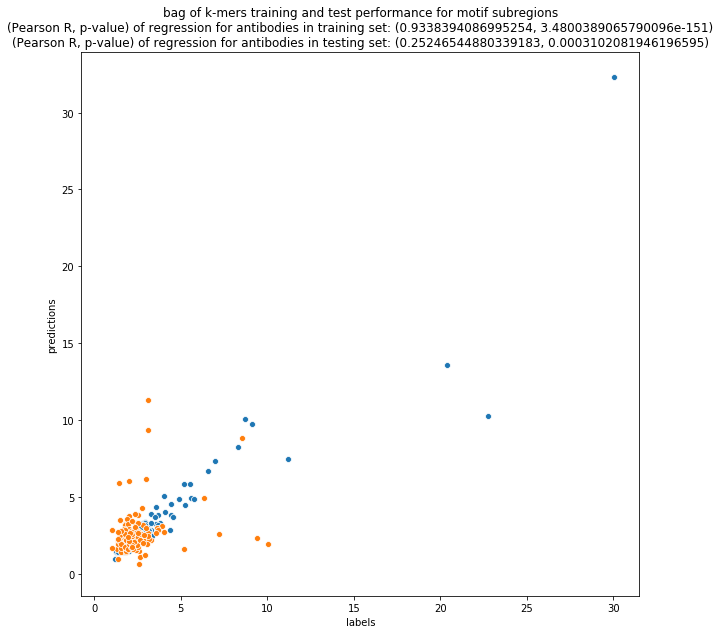

In [228]:

data = train_predictions
sns.scatterplot(x = "labels", y = "predictions", data = data)

data = test_predictions
sns.scatterplot(x = "labels", y = "predictions", data = data)

plt.gca().set_title(f"""bag of k-mers training and test performance for motif subregions
(Pearson R, p-value) of regression for antibodies in training set: {stats.pearsonr(train_predictions.labels, train_predictions.predictions)}
(Pearson R, p-value) of regression for antibodies in testing set: {stats.pearsonr(test_predictions.labels, test_predictions.predictions)}""")

plt.gcf().set_size_inches(10,10)